##### Copyright 2024 Google LLC.

In [1]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Integrating PaliGemma with Mesop
This notebook demonstrates how to use [PaliGemma](https://ai.google.dev/gemma/docs/paligemma) models with [Mesop](https://google.github.io/mesop/) to create a simple GUI application.
<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google-gemini/gemma-cookbook/blob/main/PaliGemma/Integrate_PaliGemma_with_Mesop.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

## Setup

### Select the Colab runtime
To complete this tutorial, you'll need to have a Colab runtime with sufficient resources to run the Gemma model. In this case, you can use a T4 GPU:

1. In the upper-right of the Colab window, select **▾ (Additional connection options)**.
2. Select **Change runtime type**.
3. Under **Hardware accelerator**, select **T4 GPU**.

### Gemma setup

To complete this tutorial, you'll first need to complete the setup instructions at [Gemma setup](https://ai.google.dev/gemma/docs/setup). The Gemma setup instructions show you how to do the following:

* Get access to Gemma on kaggle.com.
* Select a Colab runtime with sufficient resources to run
  the Gemma 2B model.
* Generate and configure a Kaggle username and an API key as Colab secrets.

After you've completed the Gemma setup, move on to the next section, where you'll set environment variables for your Colab environment.


### Configure your credentials

Add your your Kaggle credentials to the Colab Secrets manager to securely store it.

1. Open your Google Colab notebook and click on the 🔑 Secrets tab in the left panel. <img src="https://storage.googleapis.com/generativeai-downloads/images/secrets.jpg" alt="The Secrets tab is found on the left panel." width=50%>
2. Create new secrets: `KAGGLE_USERNAME` and `KAGGLE_KEY`
3. Copy/paste your username into `KAGGLE_USERNAME`
3. Copy/paste your key into `KAGGLE_KEY`
4. Toggle the buttons on the left to allow notebook access to the secrets.


In [2]:
import os
from google.colab import userdata

# Note: `userdata.get` is a Colab API. If you're not using Colab, set the env
# vars as appropriate for your system.
os.environ["KAGGLE_USERNAME"] = userdata.get("KAGGLE_USERNAME")
os.environ["KAGGLE_KEY"] = userdata.get("KAGGLE_KEY")

### Install dependencies
Run the cell below to install all the required dependencies.

In [3]:
!pip install -q -U keras keras-nlp
!pip install -q overrides ml_collections "einops~=0.7" sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.8/571.8 kB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.7/347.7 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 46.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 69.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 73.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 69.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.15.1 requires tensorflow<2.16,>=2.15, but you have tensorflow 2.16.2 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 1.5 MB/s eta 0:00:00


## Exploring prompting capabilities

### PaliGemma

PaliGemma is a lightweight open vision-language model (VLM) inspired by PaLI-3, and based on open components like the SigLIP vision model and the Gemma language model. PaliGemma takes both images and text as inputs and can answer questions about images with detail and context, meaning that PaliGemma can perform deeper analysis of images and provide useful insights, such as captioning for images and short videos, object detection, and reading text embedded within images.

Prompting:

* `cap {lang}\n`: Very raw short caption (from WebLI-alt)
* `caption {lang}\n`: Nice, COCO-like short captions
* `describe {lang}\n`: Somewhat longer, more descriptive captions
* `ocr`: Optical character recognition
* `answer en {question}\n`: Question answering about the image contents
* `question {lang} {answer}\n`: Question generation for a given answer
* `detect {object} ; {object}\n`: Count objects in a scene and return the bounding boxes for the objects
* `segment {object}\n`: Do image segmentation of the object in the scene

In [4]:
import os
import sys
import keras
import keras_nlp

keras.config.set_floatx("bfloat16")

In [5]:
# Load PaliGemma
paligemma = keras_nlp.models.PaliGemmaCausalLM.from_preset("pali_gemma_3b_mix_224")

100%|██████████| 861/861 [00:00<00:00, 1.19MB/s]
100%|██████████| 5.45G/5.45G [01:15<00:00, 77.7MB/s]
100%|██████████| 410/410 [00:00<00:00, 471kB/s]
100%|██████████| 4.07M/4.07M [00:00<00:00, 15.8MB/s]


In [6]:
if not os.path.exists("big_vision_repo"):
  !git clone --quiet --branch=main --depth=1 \
     https://github.com/google-research/big_vision big_vision_repo

# Append big_vision code to python import path
if "big_vision_repo" not in sys.path:
  sys.path.append("big_vision_repo")

In [7]:
import io
import re
import PIL
import requests
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import big_vision.evaluators.proj.paligemma.transfers.segmentation as segeval

# Helpers:


def crop_and_resize(image, target_size):
    """A helper function the resizes given image to the given shape"""
    width, height = image.size
    source_size = min(image.size)
    left = width // 2 - source_size // 2
    top = height // 2 - source_size // 2
    right, bottom = left + source_size, top + source_size
    return image.resize(target_size, box=(left, top, right, bottom))


def read_image(url, target_size=(224, 224)):
    """Loads images from URL"""
    headers = {"User-Agent": "My User Agent 1.0"}
    contents = io.BytesIO(requests.get(url, headers=headers, stream=True).content)
    image = Image.open(contents)
    image = crop_and_resize(image, target_size)
    image = np.array(image)

    # Remove alpha channel if neccessary.
    if image.shape[2] == 4:
        image = image[:, :, :3]
    return image


def parse_bbox_and_labels(detokenized_output: str):
    """Parses model output to extract bounding boxes"""
    matches = re.finditer(
        "<loc(?P<y0>\d\d\d\d)><loc(?P<x0>\d\d\d\d)><loc(?P<y1>\d\d\d\d)><loc(?P<x1>\d\d\d\d)>"
        " (?P<label>.+?)( ;|$)",
        detokenized_output,
    )
    labels, boxes = [], []
    fmt = lambda x: float(x) / 1024.0
    for m in matches:
        d = m.groupdict()
        boxes.append([fmt(d["y0"]), fmt(d["x0"]), fmt(d["y1"]), fmt(d["x1"])])
        labels.append(d["label"])
    return np.array(boxes), np.array(labels)


def display_boxes(image, boxes, labels, target_image_size):
    """Draws bouding boxes on the given image"""
    h, l = target_image_size
    fig, ax = plt.subplots()
    ax.imshow(image)

    for i in range(boxes.shape[0]):
        y, x, y2, x2 = boxes[i] * h
        width = x2 - x
        height = y2 - y
        # Create a Rectangle patch
        rect = patches.Rectangle(
            (x, y), width, height, linewidth=1, edgecolor="r", facecolor="none"
        )
        # Add label
        plt.text(x, y, labels[i], color="red", fontsize=12)
        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()


def parse_segments(detokenized_output: str) -> tuple[np.ndarray, np.ndarray]:
    reconstruct_masks = segeval.get_reconstruct_masks("oi")
    matches = re.finditer(
        "<loc(?P<y0>\d\d\d\d)><loc(?P<x0>\d\d\d\d)><loc(?P<y1>\d\d\d\d)><loc(?P<x1>\d\d\d\d)>"
        + "".join(f"<seg(?P<s{i}>\d\d\d)>" for i in range(16)),
        detokenized_output,
    )
    boxes, segs = [], []
    fmt_box = lambda x: float(x) / 1024.0
    for m in matches:
        d = m.groupdict()
        boxes.append(
            [fmt_box(d["y0"]), fmt_box(d["x0"]), fmt_box(d["y1"]), fmt_box(d["x1"])]
        )
        segs.append([int(d[f"s{i}"]) for i in range(16)])

    if len(boxes) == 0 or len(segs) == 0:
        return boxes, segs

    return np.array(boxes), np.array(reconstruct_masks(np.array(segs)))

#### Prompting example: Visual Question Answering

array([[[123, 122, 113],
        [ 91,  91,  69],
        [ 89,  92,  65],
        ...,
        [ 67,  76,  40],
        [ 54,  64,  28],
        [ 66,  76,  41]],

       [[ 90,  88,  76],
        [ 83,  83,  65],
        [ 89,  92,  73],
        ...,
        [ 60,  69,  34],
        [ 49,  60,  26],
        [ 61,  72,  38]],

       [[112, 121, 112],
        [143, 152, 152],
        [152, 163, 165],
        ...,
        [ 74,  89,  49],
        [ 70,  85,  44],
        [ 74,  89,  50]],

       ...,

       [[127, 175,  86],
        [129, 179,  87],
        [123, 171,  80],
        ...,
        [117, 165,  74],
        [133, 179,  87],
        [131, 176,  92]],

       [[157, 200, 107],
        [149, 195,  99],
        [146, 195,  97],
        ...,
        [154, 200, 112],
        [131, 177,  90],
        [133, 183,  99]],

       [[172, 217, 124],
        [152, 200, 105],
        [150, 202, 105],
        ...,
        [168, 218, 125],
        [148, 196, 110],
        [139, 190, 101]]], dtype=uint8)
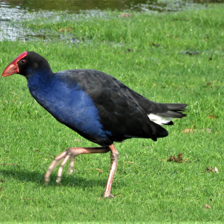

In [8]:
# Image by: Wainuio, CC BY-SA 4.0, via Wikimedia Commons
image_url = "https://upload.wikimedia.org/wikipedia/commons/8/8b/Bird-8077%2C_Kapiti%2C_North_Island%2C_New_Zealand.jpg"
image = read_image(image_url)
image

In [9]:
# Describing the image
prompt = "describe en\n"
output = paligemma.generate(
    inputs={
        "images": image,
        "prompts": prompt,
    }
)
print(output[len(prompt) :])

In this image we can see a bird on the ground. In the background there is water.


### Integration with Mesop

We will create a simple GUI application that allows users to upload images, specify prompt styles, and other arguments, such as the question or type of object, that are necessary to generate the answer.

The application will be able to provide both images and text as the output.

In [10]:
!pip install -q mesop

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 13.5 MB/s eta 0:00:00


In [11]:
import mesop as me
import mesop.labs as mel

me.colab_run()


Running server on: http://localhost:32123
 * Serving Flask app 'mesop.server.server'
 * Debug mode: off


In [12]:
from typing import Any, Dict, Literal


@me.stateclass
class State:
    """This class is responsible for storing data in the application"""

    image: list = None
    selected_task: str = None
    additional_parameter: str = None
    output: str = None
    output_type: Literal["text", "object_detection", "object_segmentation"] = "text"


def me_image_to_array(data, target_size=(224, 224)):
    """Transforms image represented by bytes to an array"""
    contents = io.BytesIO(data)
    image = Image.open(contents)
    image = crop_and_resize(image, target_size)
    image = np.array(image)

    # removes alpha channel if present
    if image.shape[2] == 4:
        image = image[:, :, :3]
    return image


def update_state_by_task(name: str) -> Dict[str, Any]:
    _task_to_params = {
        # <no params> -> Text
        "raw_short_caption": {
            "prompt": "cap en\n",
        },
        "coco_like_short_caption": {
            "prompt": "caption en\n",
        },
        "descriptive_caption": {
            "prompt": "describe en\n",
        },
        "ocr": {
            "prompt": "ocr",
        },
        # Text -> Text
        "qa": {
            "prompt": "answer en {}\n",
            "requires_additional_parameter": True,
            "additional_param_label": "What would you like to ask the model?",
        },
        "qg": {
            "prompt": "question en {}\n",
            "requires_additional_parameter": True,
            "additional_param_label": "What would be the answer for the questions?",
        },
        # Text -> Image
        "object_detection": {
            "prompt": "detect {}\n",
            "output_type": "object_detection",
            "requires_additional_parameter": True,
            "additional_param_label": "What object would you like to detect?",
        },
        "object_segmentation": {
            "prompt": "segment {}\n",
            "output_type": "object_segmentation",
            "requires_additional_parameter": True,
            "additional_param_label": "What object would you like to segment?",
        },
    }

    params = _task_to_params[name]
    state = me.state(State)
    state.prompt_template = params["prompt"]
    state.output_type = params.get("output_type", "text")
    state.requires_additional_parameter = params.get(
        "requires_additional_parameter", False
    )
    state.additional_param_label = params.get(
        "additional_param_label", "Additional parameter:"
    )


def handle_image_upload(event: me.UploadEvent):
    state = me.state(State)
    image = me_image_to_array(event.file.getvalue())
    state.image = image.tolist()
    state.output = None


def handle_select_task(event: me.SelectSelectionChangeEvent):
    state = me.state(State)
    state.output = None
    state.selected_task = event.value


def handle_additional_parameter_input(e: me.InputEvent):
    state = me.state(State)
    state.additional_parameter = e.value


def display_object_detection(boxes, labels, target_image_size=(224, 224)):
    """Displays the image with boxes around detected objects"""
    state = me.state(State)
    h, l = target_image_size
    fig, ax = plt.subplots()
    ax.imshow(state.image)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    for i in range(boxes.shape[0]):
        y, x, y2, x2 = boxes[i] * h
        width = x2 - x
        height = y2 - y
        # Create a Rectangle patch
        rect = patches.Rectangle(
            (x, y), width, height, linewidth=1, edgecolor="r", facecolor="none"
        )
        # Add label
        plt.text(x, y, labels[i], color="red", fontsize=12)
        # Add the patch to the Axes
        ax.add_patch(rect)
    me.plot(fig, style=me.Style(width="100%"))


def display_object_segmentation(
    bounding_box, segment_mask, target_image_size=(224, 224)
):
    # Initialize a full mask with the target size
    state = me.state(State)
    image = np.array(state.image)
    full_mask = np.zeros(target_image_size, dtype=np.uint8)
    target_width, target_height = target_image_size

    for bbox, mask in zip(bounding_box, segment_mask):
        y1, x1, y2, x2 = bbox
        x1 = int(x1 * target_width)
        y1 = int(y1 * target_height)
        x2 = int(x2 * target_width)
        y2 = int(y2 * target_height)

        # Ensure mask is 2D before converting to Image
        if mask.ndim == 3:
            mask = mask.squeeze(axis=-1)
        mask = Image.fromarray(mask)
        mask = mask.resize((x2 - x1, y2 - y1), resample=Image.NEAREST)
        mask = np.array(mask)
        binary_mask = (mask > 0.5).astype(np.uint8)

        # Place the binary mask onto the full mask
        full_mask[y1:y2, x1:x2] = np.maximum(full_mask[y1:y2, x1:x2], binary_mask)

    cmap = plt.get_cmap("jet")
    colored_mask = cmap(full_mask / 1.0)
    colored_mask = (colored_mask[:, :, :3] * 255).astype(np.uint8)
    blended_image = image.copy()
    mask_indices = full_mask > 0
    alpha = 0.5

    for c in range(3):
        blended_image[:, :, c] = np.where(
            mask_indices,
            (1 - alpha) * image[:, :, c] + alpha * colored_mask[:, :, c],
            image[:, :, c],
        )
    fig, ax = plt.subplots()
    ax.imshow(blended_image)
    me.plot(fig, style=me.Style(width="100%"))


def generate_content(e: me.ClickEvent):
    """Generates an answer to the users query"""
    state = me.state(State)
    prompt = (
        state.prompt_template.format(state.additional_parameter)
        if state.requires_additional_parameter
        else state.prompt_template
    )
    image = np.array(state.image)
    output = paligemma.generate(
        inputs={
            "images": image,
            "prompts": prompt,
        }
    )
    state.output = output[len(prompt) :]


@me.page(path="/app")
def app():
    """the main function of the application"""
    state = me.state(State)

    with me.box(
        style=me.Style(
            display="flex",
            flex_direction="column",
            gap=10,
            padding=me.Padding.symmetric(horizontal="30%"),
            margin=me.Margin.symmetric(vertical=48),
        )
    ):

        # Image
        me.text(
            "Upload an image to get started:",
            style=me.Style(width="100%", text_align="center"),
            type="headline-5",
        )
        with me.box(
            style=me.Style(
                display="flex", flex_direction="column", align_items="center"
            )
        ):
            me.uploader(
                label="Upload Image",
                accepted_file_types=["image/jpeg", "image/png"],
                on_upload=handle_image_upload,
            )

        # Task
        if state.image:
            me.text(
                "Choose a task:",
                style=me.Style(width="100%", text_align="center"),
                type="headline-5",
            )
            me.select(
                label="Choose PaliGemma task",
                options=[
                    me.SelectOption(
                        label="Raw short caption", value="raw_short_caption"
                    ),
                    me.SelectOption(
                        label="COCO-like short caption", value="coco_like_short_caption"
                    ),
                    me.SelectOption(
                        label="Longer, descriptive caption", value="descriptive_caption"
                    ),
                    me.SelectOption(label="Optical character recognition", value="ocr"),
                    me.SelectOption(label="Question answering", value="qa"),
                    me.SelectOption(label="Question generation", value="qg"),
                    me.SelectOption(label="Object detection", value="object_detection"),
                    me.SelectOption(
                        label="Object segmentation", value="object_segmentation"
                    ),
                ],
                on_selection_change=handle_select_task,
                style=me.Style(width="100%"),
            )

        # Generation
        if state.image and state.selected_task:

            update_state_by_task(state.selected_task)
            if state.requires_additional_parameter:
                me.text(
                    state.additional_param_label,
                    style=me.Style(width="100%", text_align="center"),
                    type="headline-5",
                )
                me.input(
                    label="Define an object (e.g. car, tree, building...)",
                    on_blur=handle_additional_parameter_input,
                    style=me.Style(width="100%"),
                )

            with me.box(
                style=me.Style(
                    display="flex", flex_direction="column", align_items="center"
                )
            ):
                me.button("Generate!", on_click=generate_content, type="flat")

            if state.output is not None:
                if state.output_type == "text":
                    me.textarea(
                        label="output",
                        readonly=True,
                        value=state.output,
                        style=me.Style(width="100%"),
                    )
                elif state.output_type == "object_detection":
                    boxes, labels = parse_bbox_and_labels(state.output)
                    display_object_detection(boxes, labels)
                elif state.output_type == "object_segmentation":
                    bboxes, seg_masks = parse_segments(state.output)
                    if len(bboxes) and len(seg_masks):
                        display_object_segmentation(bboxes, seg_masks)
                    else:
                        me.text(
                            "Sorry, cannot find the specified object on the image.",
                            style=me.Style(width="100%", text_align="center"),
                            type="headline-5",
                        )

INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (::)
 * Running on http://[::1]:32123
 * Running on http://[::1]:32123
INFO:werkzeug:Press CTRL+C to quit


In [13]:
me.colab_show(path="/app", height=800)

<IPython.core.display.Javascript object>